In [1]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
import jax
import jax.numpy as jnp

In [2]:
L = 4  # Side of the square
graph = nk.graph.Square(L)
N = graph.n_nodes

N_f = 5

hi = nkx.hilbert.SpinOrbitalFermions(N, s=None, n_fermions=N_f)

t = 1.0
V = 4.0

H = 0.0
for (i, j) in graph.edges():
    H -= t * (cdag(hi,i) * c(hi,j) + cdag(hi,j) * c(hi,i))
    H += V * nc(hi,i) * nc(hi,j)

In [3]:
# Convert the Hamiltonian to a sparse matrix
sp_h = H.to_sparse()

from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

E_gs = eig_vals[0]

print("Exact ground state energy:", E_gs)

Exact ground state energy: -6.859013554319583


In [4]:
import flax.linen as nn
from netket.utils.types import NNInitFunc
from netket.nn.masked_linear import default_kernel_init
from typing import Any, Callable, Sequence
from functools import partial
DType = Any


class LogSlaterDeterminant(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):
        # the N x Nf matrix of the orbitals
        M = self.param('M', self.kernel_init, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), self.param_dtype)

        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Find the positions of the occupied orbitals 
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            
            # Extract the Nf x Nf submatrix of M corresponding to the occupied orbitals
            A = M[R]

            return nk.jax.logdet_cmplx(A)

        return log_sd(n)

In [5]:
# Create the Slater determinant model
model = LogSlaterDeterminant(hi)

# Define the Metropolis-Hastings sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.05)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=slater_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [6]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -5.026-0.000j ± 0.035 [σ²=4.663, R̂=1.0023]
Relative error   : 0.2671801835700823


In [7]:
class LogNeuralJastrowSlater(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    hidden_units: int
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):
       
        @partial(jnp.vectorize, signature='(n)->()')
        def log_wf(n):
            #Bare Slater Determinant (N x Nf matrix of the orbital amplitudes) 
            M = self.param('M', self.kernel_init, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), self.param_dtype)

            #Construct the Neural Jastrow
            J = nn.Dense(self.hidden_units, param_dtype=self.param_dtype)(n)
            J = jax.nn.tanh(J)
            J = J.sum()
            
            # Find the positions of the occupied orbitals
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            # Select the N rows of M corresponding to the occupied orbitals, obtaining the Nf x Nf slater matrix
            A = M[R]
            # compute the (log) determinant and add the Jastrow
            # (when exponentiating this becomes a product of the slater and jastrow terms)
            return nk.jax.logdet_cmplx(A)+J

        return log_wf(n)

In [8]:
# Create a Neural Jastrow Slater wave function 
model = LogNeuralJastrowSlater(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=nj_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [9]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -6.827-0.000j ± 0.011 [σ²=0.483, R̂=1.0014]
Relative error   : 0.0046584873121586065


In [10]:
class LogNeuralBackflow(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    hidden_units: int
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):
       
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Bare Slater Determinant (N x Nf matrix of the orbital amplitudes) 
            M = self.param('M', self.kernel_init, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), self.param_dtype)

            # Construct the Backflow. Takes as input strings of $N$ occupation numbers, outputs an $N x Nf$ matrix
            # that modifies the bare orbitals.
            F = nn.Dense(self.hidden_units, param_dtype=self.param_dtype)(n)
            F = jax.nn.tanh(F)
            # last layer, outputs N x Nf values
            F = nn.Dense(self.hilbert.n_orbitals * self.hilbert.n_fermions, param_dtype=self.param_dtype)(F)
            # reshape into M and add
            M += F.reshape(M.shape)
            
            #Find the positions of the occupied, backflow-modified orbitals
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            A = M[R]
            return nk.jax.logdet_cmplx(A)

        return log_sd(n)

In [11]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=bf_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [12]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)
print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -6.816-0.000j ± 0.010 [σ²=0.417, R̂=1.0024]
Relative error   : 0.006276276566685517


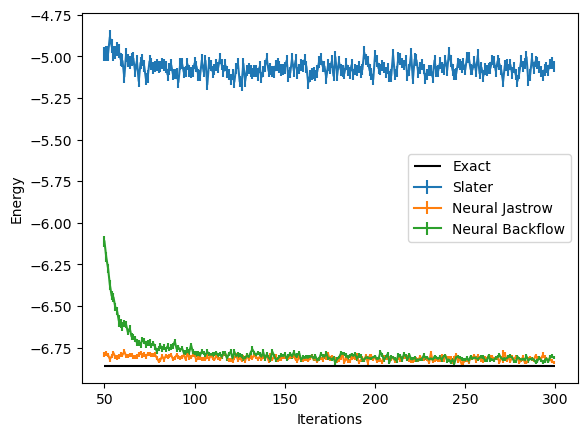

In [14]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

start = 50

end = 300

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters[start:end], data["Energy"].Mean.real[start:end], yerr=data["Energy"].Sigma[start:end],label=label)

plt.hlines([E_gs], xmin=start, xmax=end, color='black', label="Exact")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()